In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

Load Dataset

In [12]:
data_path = r"C:\Users\fairo\Desktop\DDOS_Detection_for_IOT\data\UL-ECE-UDP-DDoS-H-IoT2025.csv"

df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (99887, 18)


,timestamp,time_elapsed,node_id,protocol,protocol_des,source_ip,source_ip_des,destination_ip,destination_ip_des,payload_size,total_messages,total_messages_same_node,frequency,mean_frequency,monitoring_frequency,monitoring_total_messages,monitoring_total_messages_same_node,outcome
0,0.016516,0.0,19,0,ns3::Ipv4Header,7,7.0.0.17,0,7.0.0.2,512.0,1,1,100.000000,100.000000,20.0,5,1,0
1,0.016516,0.0,20,0,ns3::Ipv4Header,8,7.0.0.18,0,7.0.0.2,512.0,2,1,50.000000,75.000000,20.0,5,1,0
2,0.016516,0.0,21,0,ns3::Ipv4Header,9,7.0.0.19,0,7.0.0.2,512.0,3,1,33.333333,61.111111,20.0,5,1,0
3,0.016516,0.0,22,0,ns3::Ipv4Header,10,7.0.0.20,0,7.0.0.2,512.0,4,1,25.000000,52.083333,20.0,5,1,0
4,0.016516,0.0,23,0,ns3::Ipv4Header,11,7.0.0.21,0,7.0.0.2,512.0,5,1,20.000000,45.666667,20.0,5,1,0


Basic Dataset Inspection

In [13]:
# Column names
print("Columns:\n", df.columns.tolist())

# Data types
df.info()

Columns:
 ['timestamp', 'time_elapsed', 'node_id', 'protocol', 'protocol_des', 'source_ip', 'source_ip_des', 'destination_ip', 'destination_ip_des', 'payload_size', 'total_messages', 'total_messages_same_node', 'frequency', 'mean_frequency', 'monitoring_frequency', 'monitoring_total_messages', 'monitoring_total_messages_same_node', 'outcome']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99887 entries, 0 to 99886
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   timestamp                            99887 non-null  float64
 1   time_elapsed                         99887 non-null  float64
 2   node_id                              99887 non-null  int64  
 3   protocol                             99887 non-null  int64  
 4   protocol_des                         99887 non-null  object 
 5   source_ip                            99887 non-null  int64  
 6   source_ip_des

Identify Label Column

In [14]:
possible_labels = [col for col in df.columns if 
                   col.lower() in ["label", "class", "attack", "target"]]

print("Possible label columns:", possible_labels)

Possible label columns: []


Label Distribution 

In [17]:
label_col = "outcome"

df[label_col].value_counts()


outcome
1    51893
0    47994
Name: count, dtype: int64

In [18]:
df[label_col].unique()


array([0, 1])

Check Missing & Duplicate Values

In [19]:
# Percentage distribution
df[label_col].value_counts(normalize=True) * 100


outcome
1    51.951705
0    48.048295
Name: proportion, dtype: float64

In [16]:
print("Missing values:\n", df.isnull().sum())

print("Duplicate rows:", df.duplicated().sum())


Missing values:
 timestamp                              0
time_elapsed                           0
node_id                                0
protocol                               0
protocol_des                           0
source_ip                              0
source_ip_des                          0
destination_ip                         0
destination_ip_des                     0
payload_size                           0
total_messages                         0
total_messages_same_node               0
frequency                              0
mean_frequency                         0
monitoring_frequency                   0
monitoring_total_messages              0
monitoring_total_messages_same_node    0
outcome                                0
dtype: int64
Duplicate rows: 0


In [20]:
# Define Label Column

label_col = "outcome"


# Drop Non-Informative Columns
* timestamp, time_elapsed → temporal noise
* IP addresses → identifiers, not behavior
* Descriptions → redundant text

IP addresses and timestamps were removed as they do not represent traffic behavior and may bias the model

In [23]:
drop_cols = [
    "timestamp",
    "time_elapsed",
    "source_ip",
    "source_ip_des",
    "destination_ip",
    "destination_ip_des"
]

df_clean = df.drop(columns=drop_cols)
print("Shape after dropping columns:", df_clean.shape)


Shape after dropping columns: (99887, 12)


In [24]:
# Separate Features & Label
X = df_clean.drop(columns=[label_col])
y = df_clean[label_col]

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (99887, 11)
Labels shape: (99887,)


# Identify Categorical Columns

In [27]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)


Categorical columns: ['protocol_des']
Numerical columns: ['node_id', 'protocol', 'payload_size', 'total_messages', 'total_messages_same_node', 'frequency', 'mean_frequency', 'monitoring_frequency', 'monitoring_total_messages', 'monitoring_total_messages_same_node']


# Encode Categorical Features

In [28]:
X_encoded = pd.get_dummies(
    X,
    columns=cat_cols,
    drop_first=True
)

print("Encoded feature shape:", X_encoded.shape)


Encoded feature shape: (99887, 10)


In [29]:
X_encoded.head()


,node_id,protocol,payload_size,total_messages,total_messages_same_node,frequency,mean_frequency,monitoring_frequency,monitoring_total_messages,monitoring_total_messages_same_node
0,19,0,512.0,1,1,100.000000,100.000000,20.0,5,1
1,20,0,512.0,2,1,50.000000,75.000000,20.0,5,1
2,21,0,512.0,3,1,33.333333,61.111111,20.0,5,1
3,22,0,512.0,4,1,25.000000,52.083333,20.0,5,1
4,23,0,512.0,5,1,20.000000,45.666667,20.0,5,1


# FEATURE SCALING

In [31]:
# Import Scaler
from sklearn.preprocessing import StandardScaler

# Initialize Scaler
scaler = StandardScaler()

# Apply Scaling
X_scaled = scaler.fit_transform(X_encoded)

# Convert Back to DataFrame 
X_scaled = pd.DataFrame(
    X_scaled,
    columns=X_encoded.columns
)

X_scaled.head()

# Sanity Check
X_scaled.describe()


,node_id,protocol,payload_size,total_messages,total_messages_same_node,frequency,mean_frequency,monitoring_frequency,monitoring_total_messages,monitoring_total_messages_same_node
count,9.988700e+04,99887.0,99887.0,9.988700e+04,9.988700e+04,9.988700e+04,9.988700e+04,9.988700e+04,9.988700e+04,9.988700e+04
mean,1.527972e-16,0.0,0.0,-7.739451e-17,-1.912100e-16,-4.492865e-16,-2.731571e-16,6.470408e-16,-3.232359e-16,1.974698e-16
std,1.000005e+00,0.0,0.0,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.918974e+00,0.0,0.0,-1.732033e+00,-1.463657e+00,-2.666796e+00,-5.251238e-01,-2.954132e+00,-7.069077e+00,-2.849378e+00
25%,-9.079419e-01,0.0,0.0,-8.660167e-01,-8.015487e-01,-8.035550e-01,-4.435983e-01,-1.116199e+00,-1.231046e-01,-9.410747e-01
50%,2.715954e-01,0.0,0.0,0.000000e+00,-1.394407e-01,-5.233834e-01,-2.509848e-01,7.226932e-01,4.611682e-01,9.672289e-01
75%,7.771114e-01,0.0,0.0,8.660167e-01,5.226674e-01,1.006443e+00,3.635585e-01,7.336277e-01,4.835081e-01,9.672289e-01
max,1.451133e+00,0.0,0.0,1.732033e+00,2.581383e+00,4.660257e+01,1.424928e+02,7.749452e+00,4.835081e-01,9.672289e-01


# Train–Test Split
`Stratified splitting wILL used to preserve the class distribution in both training and testing sets`

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y   
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (79909, 10)
Test size: (19978, 10)


# Train Random Forest Model

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Model Evaluation

In [34]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9599
           1       1.00      1.00      1.00     10379

    accuracy                           1.00     19978
   macro avg       1.00      1.00      1.00     19978
weighted avg       1.00      1.00      1.00     19978



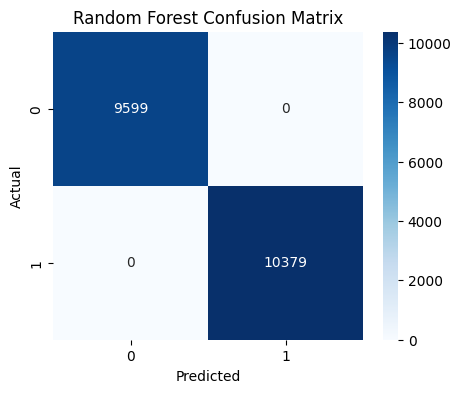

In [35]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


# Cross-Validation

In [36]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    rf_model,
    X_scaled,
    y,
    cv=5,
    scoring="f1"
)

print("CV F1 scores:", scores)
print("Mean F1:", scores.mean())


CV F1 scores: [0.94032365 0.99903587 1.         1.         1.        ]
Mean F1: 0.9878719033642314


# Extract Feature Importances